In [2]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import geopandas as gp
import datetime
# import meteolib as meteo
# import evaplib as evap
from datetime import date
import pandas as pd
from scipy import stats as stats
import numpy as np
import urllib3
import glob
# import daymetpy as dm
import time
import sys
import scipy

In [10]:
fs= glob.glob('../data/well_data/*.csv')
dfs = {}
for f in fs: 
    wellnum = f.split('/')[-1][:-4]
    df = pd.read_csv(f, header=None)
    df = df.loc[~np.isnan(df[0])]
    df.columns = ['year', 'month', 'day', 'hour', 'minute', 'second', 'val']
    df['d'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
    df = df.set_index('d')
    df = df[['val']]
    df.val = df.val.interpolate(limit=24)
    dfs[wellnum] = df
    print(df.index[0])
    

2007-10-18 10:30:00
2007-10-18 10:30:00
2007-10-18 10:30:00
2007-10-17 18:00:00
2007-10-17 16:04:00
2007-10-17 16:04:00
2011-02-09 16:30:00
2011-02-10 13:30:00
2011-02-09 16:00:00
2007-10-17 14:30:00
2011-02-09 16:00:00
2011-02-09 10:00:00


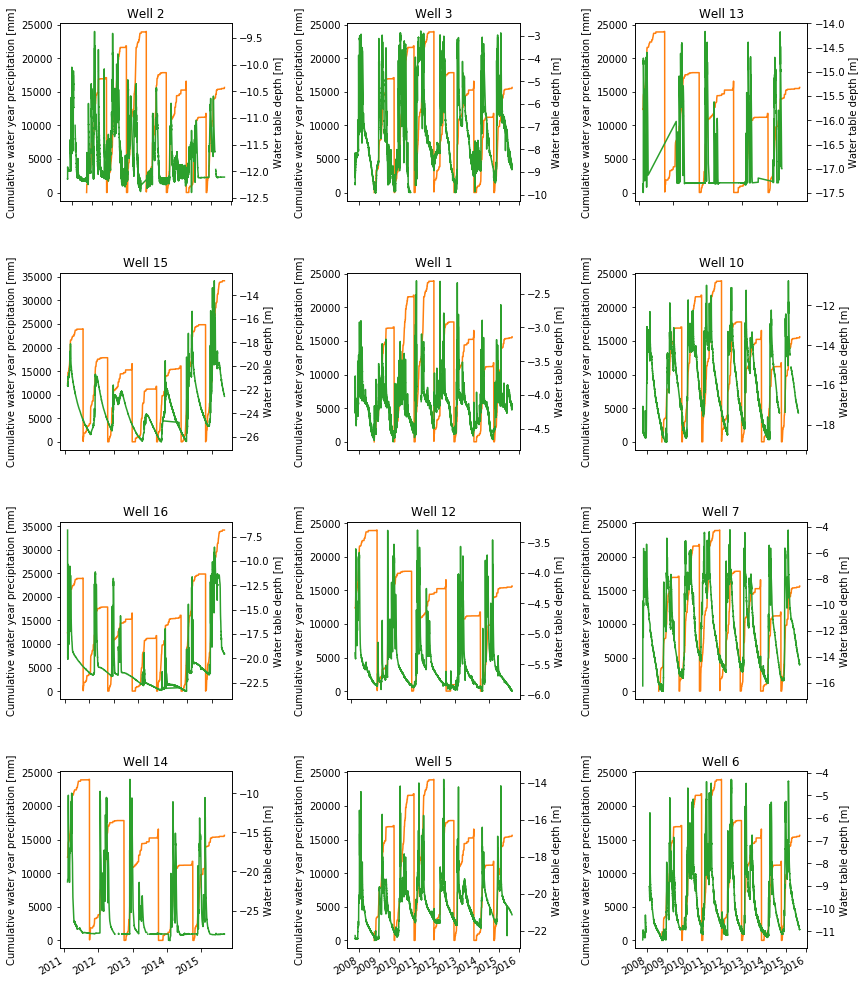

In [4]:
ppt = pd.read_pickle('./data/elder_ppt.p')
q = pd.read_pickle('./data/elder_runoff.p')
ppt['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
# for wellnum in dfs.keys():
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()*dt
    
nrows = 4
ncols = 3
wells = list(dfs)
f, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(12,14))
for i in range(nrows):
    for j in range(ncols):
        well = wells[ncols*i + j]
        df = dfs[well]
        ax = axs[i,j]
        ppttemp = ppt.loc[(ppt.index > df.index[0])&(ppt.index<df.index[-1])]
        ax.plot(1000*ppttemp.cumulative, c='C1')
        ax.set_title('Well ' + well)
        ax.set_ylabel('Cumulative water year precipitation [mm]')
        ax2 = ax.twinx()
        ax2.plot(df.val, c='C2', label = 'Water table depth')
        ax2.plot(np.nan, c='C1', label = 'Cumulative precipitation')
        ax2.set_ylabel('Water table depth [m]')

#         leg = ax2.legend(loc='best', ncol=2)
#         leg.set_alpha(1.0)
#         f.tight_layout()
#         f.savefig('./data/save_well_plots/' + well + '.pdf')
f.autofmt_xdate()
f.tight_layout()

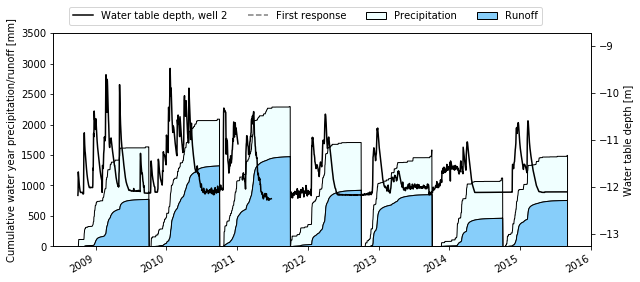

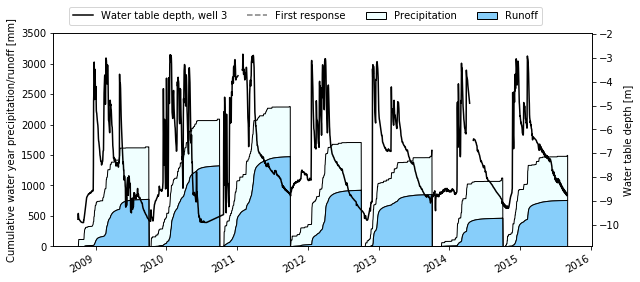

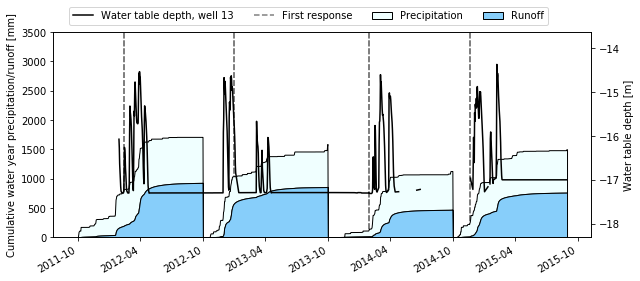

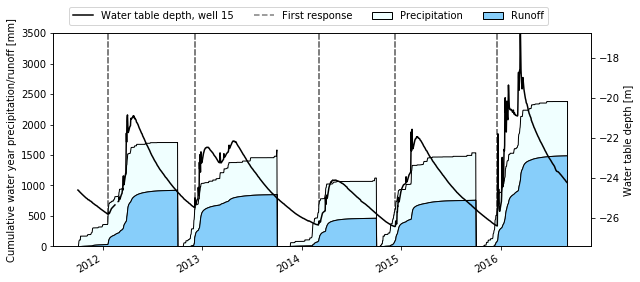

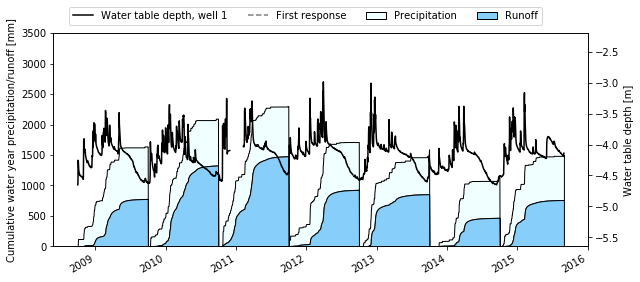

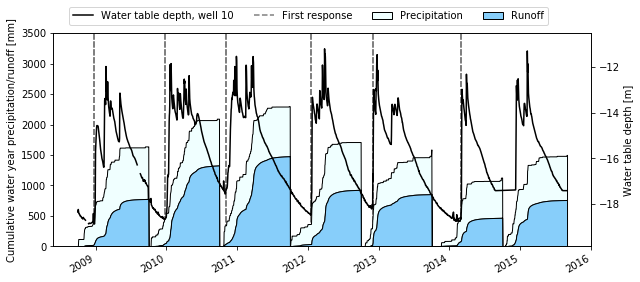

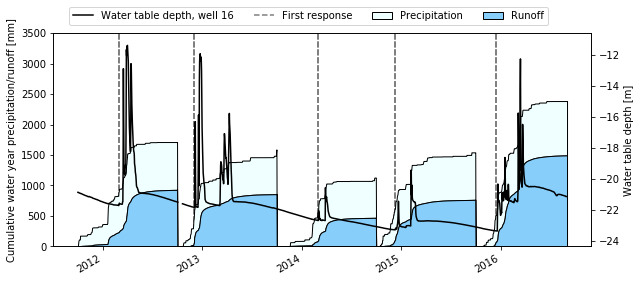

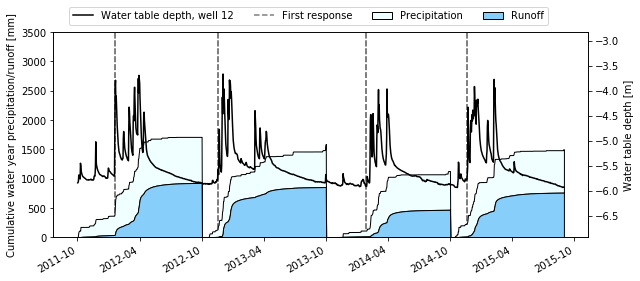

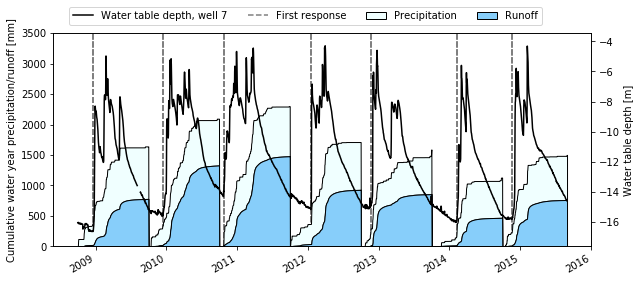

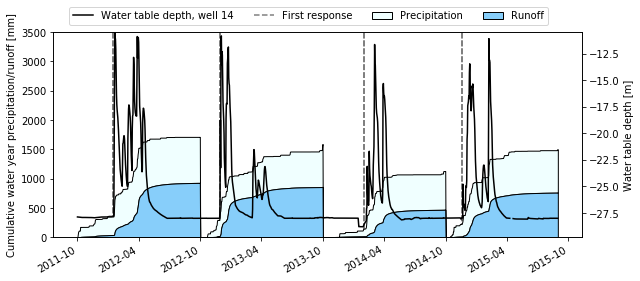

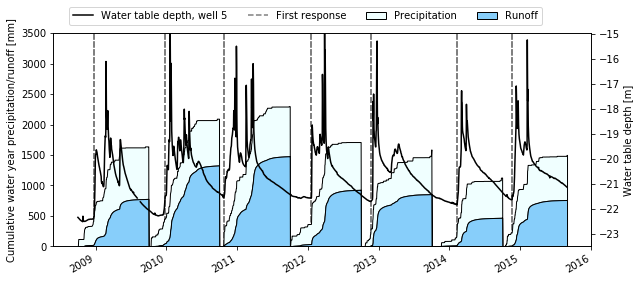

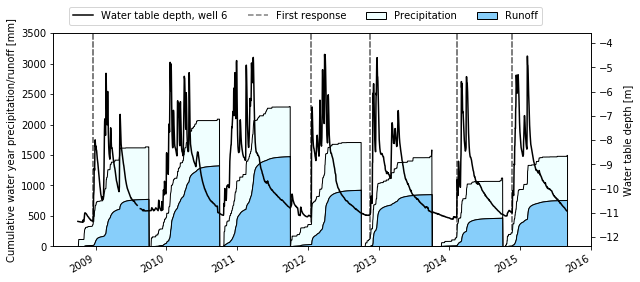

In [6]:
resp = pd.read_csv('./data/response.csv', header=-1)
resp.columns = ['well', 'year', 'month', 'day', 'wy']
resp['date'] = pd.to_datetime(resp[['year', 'month', 'day']])
rec = pd.read_csv('./data/recession.csv', header=-1)
rec.columns = ['well', 'year', 'month', 'day', 'wy']
rec['date'] = pd.to_datetime(rec[['year', 'month', 'day']])

ppt = pd.read_pickle('./data/elder_ppt.p')
q = pd.read_pickle('./data/elder_runoff.p')
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
# for wellnum in dfs.keys():
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    q.loc[wystart:wyend, 'cumulative'] = q.q.loc[wystart:wyend].cumsum()
    
    

wells = dfs.keys()
for well in wells:
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
    f,ax = plt.subplots(1,figsize=(9,4.))
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')

  
    
    datex = pd.to_datetime(resp.loc[(resp.well==int(well))&(~np.isnan(resp.day))
                                   &(resp.date>df.index[0])&(resp.date<df.index[-1])].date.values)
    datex = datex.to_pydatetime()
    #     datex = datex[(datex>df.index[0])&(datex<df.index[-1])]
#     datey = np.zeros(len(datex))

    for x in datex:
        ax.plot([datex, datex], [0,4000],ls='--',c='grey',zorder=0)
    ax.fill_between(ppttemp.index, qtemp,  ppttemp, facecolor='azure', label='Precipitation',**{'edgecolor':'k'})
    ax.fill_between(ppttemp.index, 0,  qtemp, label='Runoff', facecolor='lightskyblue',**{'edgecolor':'k'})
    ax.plot(np.nan, 'k', label='Water table depth, well ' + well)
    ax.plot(np.nan, '--',c='grey', label='First response')
    ax.set_xticks(dr.to_pydatetime())
    ax.set_xticklabels([str(dr[i].month)+'-'+str(dr[i].year) for i in range(len(dr))])


    ax2 = ax.twinx()
    ax2.plot(df.val, c='k', label = 'Water table depth')
    ax2.set_ylim([np.min(df.val.rolling(window=5).mean())-1, 1+np.max(df.val.rolling(window=5).mean())])
    ax2.plot(np.nan, c='k', label = 'Cumulative precipitation')
    ax2.set_ylabel('Water table depth [m]')
    

    ax.set_ylabel('Cumulative water year precipitation/runoff [mm]')
    ax.set_ylim([0,3500])
    
    ax.legend(bbox_to_anchor=[0.02, 1.08], loc='center left',ncol=4)

#         leg = ax2.legend(loc='best', ncol=2)
#         leg.set_alpha(1.0)
#         f.tight_layout()
        
    f.autofmt_xdate()
    f.tight_layout()
#     f.savefig('./plots/save_well_plots/' + well + '.pdf')




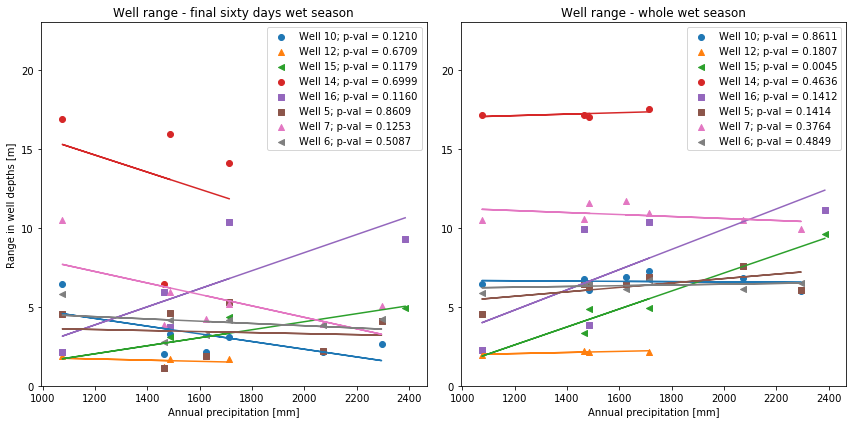

In [97]:
resp = pd.read_csv('./data/response.csv', header=-1)
resp.columns = ['well', 'year', 'month', 'day', 'wy']
resp['date'] = pd.to_datetime(resp[['year', 'month', 'day']])
rec = pd.read_csv('./data/recession.csv', header=-1)
rec.columns = ['well', 'year', 'month', 'day', 'wy']
rec['date'] = pd.to_datetime(rec[['year', 'month', 'day']])

ppt = pickle.load(  open('./data/elder_ppt.p', 'rb') )
q = 10*pickle.load( open('./data/elder_runoff.p', 'rb') )
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
# for wellnum in dfs.keys():
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    q.loc[wystart:wyend, 'cumulative'] = q.runoff.loc[wystart:wyend].cumsum()
    
    
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
wells = dfs.keys()
cm = sns.color_palette('bright', len(wells))
for i in range(len(wells)):
    well = wells[i]
    if (well=='13')|(well=='2')|(well=='1')|(well=='3'):
        continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))

    years = list(set(df.index.year))
    years.sort()
    years = [years[j] for j in range(len(years)) if years[j]!=2007]
    years = [years[j] for j in range(len(years)) if years[j]!=2017]
    yearly_ranges = []
    yearly_ppt = []
    markers = ['o', 's', '^', '<']
    for year in years[1:]:
        starttime = pd.to_datetime('10-' + str(year-1))
        endtime = pd.to_datetime('8-' + str(year))
        yearly_ppt.append(ppt[starttime:endtime].ppt.sum())
        endtime = pd.to_datetime(rec.date.loc[(rec.year==year)&(rec.well==int(well))].values[0])
        starttime = endtime - datetime.timedelta(days=60)
        yearly_ranges.append(float(df[starttime:endtime].max() - df[starttime:endtime].min()))


    x = np.array(yearly_ppt)
    y = np.array(yearly_ranges)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    ax1.scatter(x, y, label='Well ' + str(well) + '; p-val = %.4f'%p_value, marker=markers[np.mod(i,4)])
    ypredict = slope*x + intercept
    ax1.plot(x,ypredict)
    ax1.set_xlabel('Annual precipitation [mm]')
    ax1.set_ylabel('Range in well depths [m]')
#     plt.tight_layout()
#     plt.savefig('./plots/well_range_plots/' + str(well) + '.pdf')
        
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')
    
ax1.set_ylim([0, 23])



for i in range(len(wells)):
    well = wells[i]
    if (well=='13')|(well=='2')|(well=='1')|(well=='3'):
        continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))

    years = list(set(df.index.year))
    years.sort()
    years = [years[j] for j in range(len(years)) if years[j]!=2007]
    years = [years[j] for j in range(len(years)) if years[j]!=2017]
    yearly_ranges = []
    yearly_ppt = []
    markers = ['o', 's', '^', '<']
    for year in years[1:]:
        starttime = pd.to_datetime('10-' + str(year-1))
        endtime = pd.to_datetime('8-' + str(year))
        yearly_ppt.append(ppt[starttime:endtime].ppt.sum())
#         endtime = pd.to_datetime(rec.date.loc[(rec.year==year)&(rec.well==int(well))].values[0])
#         starttime = endtime - datetime.timedelta(days=60)
        yearly_ranges.append(float(df[starttime:endtime].max() - df[starttime:endtime].min()))


    x = np.array(yearly_ppt)
    y = np.array(yearly_ranges)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    ax2.scatter(x, y, label='Well ' + str(well) + '; p-val = %.4f'%p_value, marker=markers[np.mod(i,4)])
    ypredict = slope*x + intercept
    ax2.plot(x,ypredict)
    ax2.set_xlabel('Annual precipitation [mm]')
#     plt.tight_layout()
#     plt.savefig('./plots/well_range_plots/' + str(well) + '.pdf')
        
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')
    
ax2.set_ylim([0, 23])
ax1.legend(loc='best', ncol=1)
ax2.legend(loc='best', ncol=1)

ax1.set_title('Well range - final sixty days wet season')
ax2.set_title('Well range - whole wet season')


f.tight_layout()
plt.savefig('./plots/wellrange_vs_precip.pdf')

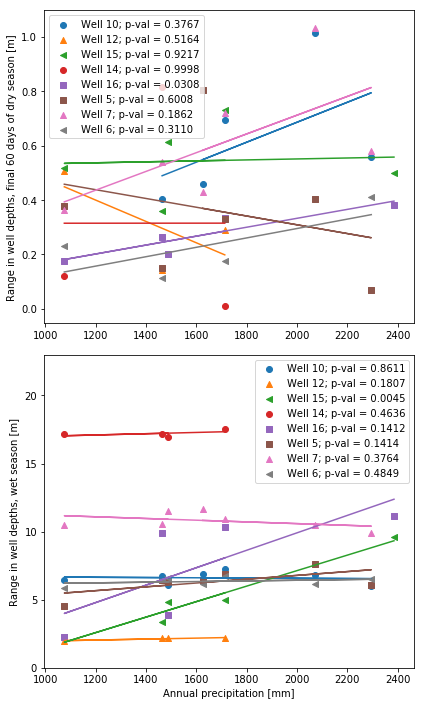

In [226]:
resp = pd.read_csv('./data/response.csv', header=-1)
resp.columns = ['well', 'year', 'month', 'day', 'wy']
resp['date'] = pd.to_datetime(resp[['year', 'month', 'day']])
rec = pd.read_csv('./data/recession.csv', header=-1)
rec.columns = ['well', 'year', 'month', 'day', 'wy']
rec['date'] = pd.to_datetime(rec[['year', 'month', 'day']])

ppt = pickle.load(  open('./data/elder_ppt.p', 'rb') )
q = 10*pickle.load( open('./data/elder_runoff.p', 'rb') )
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
# for wellnum in dfs.keys():
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    q.loc[wystart:wyend, 'cumulative'] = q.runoff.loc[wystart:wyend].cumsum()
    
    
f, (ax1, ax2) = plt.subplots(2,1,figsize=(6,10))
wells = dfs.keys()
cm = sns.color_palette('bright', len(wells))
for i in range(len(wells)):
    well = wells[i]
    if (well=='13')|(well=='2')|(well=='1')|(well=='3'):
        continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))

    years = list(set(df.index.year))
    years.sort()
    years = [years[j] for j in range(len(years)) if years[j]!=2007]
    years = [years[j] for j in range(len(years)) if years[j]!=2017]
    yearly_ranges = []
    yearly_ppt = []
    markers = ['o', 's', '^', '<']
    for year in years[1:]:
        starttime = pd.to_datetime('10-' + str(year-1))
        endtime = pd.to_datetime('8-' + str(year))
        yearly_ppt.append(ppt[starttime:endtime].ppt.sum())
        endtime = pd.to_datetime(resp.date.loc[(resp.wy==year+1)&(resp.well==int(well))].values[0])
        starttime = endtime - datetime.timedelta(days=60)
        if (starttime in df.index)&(endtime in df.index):
            yearly_ranges.append(float(df[starttime:endtime].max() - df[starttime:endtime].min()))
        else: 
            yearly_ppt.pop()

    x = np.array(yearly_ppt)
    y = np.array(yearly_ranges)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    ax1.scatter(x, y, label='Well ' + str(well) + '; p-val = %.4f'%p_value, marker=markers[np.mod(i,4)])
    ypredict = slope*x + intercept
    ax1.plot(x,ypredict)
#     ax1.set_xlabel('Annual precipitation [mm]')
    ax1.set_ylabel('Range in well depths [m]')
#     plt.tight_layout()
#     plt.savefig('./plots/well_range_plots/' + str(well) + '.pdf')
        
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')
    



for i in range(len(wells)):
    well = wells[i]
    if (well=='13')|(well=='2')|(well=='1')|(well=='3'):
        continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))

    years = list(set(df.index.year))
    years.sort()
    years = [years[j] for j in range(len(years)) if years[j]!=2007]
    years = [years[j] for j in range(len(years)) if years[j]!=2017]
    yearly_ranges = []
    yearly_ppt = []
    markers = ['o', 's', '^', '<']
    for year in years[1:]:
        starttime = pd.to_datetime('10-' + str(year-1))
        endtime = pd.to_datetime('8-' + str(year))
        yearly_ppt.append(ppt[starttime:endtime].ppt.sum())
#         endtime = pd.to_datetime(rec.date.loc[(rec.year==year)&(rec.well==int(well))].values[0])
#         starttime = endtime - datetime.timedelta(days=60)
        yearly_ranges.append(float(df[starttime:endtime].max() - df[starttime:endtime].min()))


    x = np.array(yearly_ppt)
    y = np.array(yearly_ranges)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    ax2.scatter(x, y, label='Well ' + str(well) + '; p-val = %.4f'%p_value, marker=markers[np.mod(i,4)])
    ypredict = slope*x + intercept
    ax2.plot(x,ypredict)
    ax2.set_xlabel('Annual precipitation [mm]')
#     plt.tight_layout()
#     plt.savefig('./plots/well_range_plots/' + str(well) + '.pdf')
        
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')
    
ax2.set_ylim([0, 23])
ax1.legend(loc='best', ncol=1)
ax2.legend(loc='best', ncol=1)

ax1.set_ylabel('Range in well depths, final 60 days of dry season [m]')
ax2.set_ylabel('Range in well depths, wet season [m]')





f.tight_layout()
plt.savefig('./plots/wellrange_vs_precip.pdf')

 Well 10, 2007-10-17 to 2015-09-01, max = -11.21, min = -18.86
 Well 13, 2011-02-09 to 2015-09-01, max = -14.37, min = -17.47
 Well 12, 2011-02-09 to 2015-09-01, max = -3.67, min = -5.94
 Well 15, 2011-02-10 to 2016-12-31, max = -16.77, min = -26.42
 Well 14, 2011-02-09 to 2015-09-01, max = -10.18, min = -28.79
 Well 16, 2011-02-09 to 2016-12-31, max = -11.08, min = -23.36
 Well 1, 2007-10-17 to 2015-09-01, max = -2.99, min = -4.66
 Well 2, 2007-10-17 to 2015-09-01, max = -9.48, min = -12.29
 Well 5, 2007-10-18 to 2015-09-01, max = -14.68, min = -22.51
 Well 7, 2007-10-18 to 2015-09-01, max = -4.29, min = -16.66
 Well 6, 2007-10-18 to 2015-09-01, max = -4.46, min = -11.39


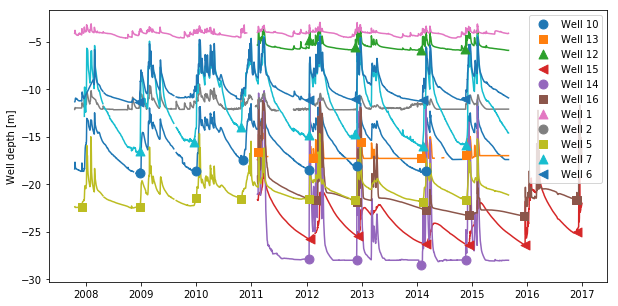

In [20]:
resp = pd.read_csv('./data/response.csv', header=-1)
resp.columns = ['well', 'year', 'month', 'day', 'wy']
resp['date'] = pd.to_datetime(resp[['year', 'month', 'day']])
rec = pd.read_csv('./data/recession.csv', header=-1)
rec.columns = ['well', 'year', 'month', 'day', 'wy']
rec['date'] = pd.to_datetime(rec[['year', 'month', 'day']])

ppt = pickle.load(  open('./data/elder_ppt.p', 'rb') )
q = 10*pickle.load( open('./data/elder_runoff.p', 'rb') )
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
# for wellnum in dfs.keys():
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    q.loc[wystart:wyend, 'cumulative'] = q.runoff.loc[wystart:wyend].cumsum()
    
    
f, (ax1) = plt.subplots(1,figsize=(10,5))
wells = dfs.keys()
cm = sns.color_palette('bright', len(wells))
maxwell = {}
minwell = {}
for i in range(len(wells)):
    well = wells[i]
    if (well=='3'):
        continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))

    years = list(set(df.index.year))
    years.sort()
    years = [years[j] for j in range(len(years)) if years[j]!=2007]
    years = [years[j] for j in range(len(years)) if years[j]!=2017]
    yearly_ranges = []
    yearly_ppt = []
    yearly_min = []
    yearly_min_date = []
    markers = ['o', 's', '^', '<']

        
    mindate = resp.loc[(resp.well==int(well))&(~('2017' in resp.date))].date.values
    minval = df.val.loc[pd.to_datetime(mindate)].values
    plt.scatter(mindate, minval, marker=markers[np.mod(i,4)], label='Well ' + well, zorder=20, s=80)
    plt.plot(df.val.loc[df.index.year<2017], label='_nolegend_')
    maxwell[well] = df.val.loc[df.index.year<2017].max()
    minwell[well] = df.val.loc[df.index.year<2017].min()
    idx = df.loc[df.index.year<2017].index.values
    
    print(' Well %s, %s to %s, max = %.2f, min = %.2f'%(str(well), pd.to_datetime(idx[0]).date(), pd.to_datetime(idx[-1]).date(),  maxwell[well], minwell[well]))
#     plt.scatter(yearly_min_date, df.val.loc[yearly_min_date], marker=markers[np.mod(i,4)])
#     ax1.set_xlabel('Annual precipitation [mm]')
    ax1.set_ylabel('Well depth [m]')
#     plt.tight_layout()
#     plt.savefig('./plots/well_range_plots/' + str(well) + '.pdf')
        
    
    ppttemp = ppt.loc[(ppt.index<='9-2016')&(ppt.index>'10-' + str(df.index[0].year))&(ppt.index<df.index[-1])&(ppt.index > '10-2008')]
    ppttemp = ppttemp.cumulative.resample('D').mean().interpolate()
    qtemp = q.cumulative.loc[ppttemp.index].interpolate()
    df = df.loc[(df.index>=ppttemp.index[0])&(df.index<=ppttemp.index[-1])]
    
    
    
    mindate = '10-' + str(df.index.year.min()-1)
    maxdate = '9-' + str(df.index.year.max())
    dr = pd.date_range(mindate,maxdate,freq='6MS')
ax1.legend()


# ax2.set_ylim([0, 23])
# ax1.legend(loc='best', ncol=1)
# ax2.legend(loc='best', ncol=1)

# ax1.set_ylabel('Range in well depths, final 60 days of dry season [m]')
# ax2.set_ylabel('Range in well depths, wet season [m]')





# f.tight_layout()
# plt.savefig('./plots/well_depth_mins_ts.pdf')
plt.savefig('/Users/daviddralle/Desktop/well_ts.pdf')

In [10]:
starts = pd.to_datetime(['2009-05-06', '2010-06-10', '2011-06-29', '2012-05-04', '2013-04-08', '2014-04-29'])
stops = pd.to_datetime(['2009-09-13', '2010-09-19', '2011-09-25', '2012-10-13', '2013-09-20', '2014-09-16'])



ppt = pd.read_pickle('./data/elder_ppt.p')
q = pd.read_pickle('./data/elder_runoff.p')
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    q.loc[wystart:wyend, 'cumulative'] = q.q.loc[wystart:wyend].cumsum()

    
wells = list(dfs.keys())
cm = sns.color_palette('bright', len(wells))
maxwell = {}
minwell = {}
toconcat = []
for i in range(len(wells)):
    well = wells[i]
#     if (well=='3'):
#         continue
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
#     f,ax = plt.subplots(1,figsize=(9,4.))
    start_depths = []
    summeryear = []
    diffs = []
    for k in range(len(starts)): 
        start = starts[k]
        stop = stops[k]
        try: 
            start_depths.append(df.val.loc[start])
        except:
            start_depths.append(np.nan)
        summeryear.append(start.year)

    end_depths = []
    for stop in stops: 
        try: 
            
            end_depths.append(df.val.loc[stop])

        except:
            end_depths.append(np.nan)
            
    tempdf = pd.DataFrame.from_dict({'Summer recession start, W'+wells[i]:start_depths, 'Summer recession end, W'+wells[i]:end_depths})
    tempdf.index = summeryear
    toconcat.append(tempdf)

startstop = pd.concat(toconcat, axis=1)

In [11]:
for i,well in enumerate(wells):
    startstop['Delta, W'+well] = startstop['Summer recession start, W'+wells[i]] - startstop['Summer recession end, W'+wells[i]]
    


In [145]:
startstop.T.to_csv('/Users/daviddralle/Desktop/summer_recession_wells.csv')

In [10]:
years = list(set(ppt.index.year))
years.sort()
tots = []
for year in years[:-2]:
    startdate = '10-1-' + str(year)
    enddate = '9-30-' + str(year+1)
    tots.append(ppt.ppt.loc[startdate:enddate].sum())
    
print np.max(tots)
print np.min(tots)

2385.2378
1130.173


In [72]:
dfq = pd.read_pickle('./data/elder_runoff.p')
mins = []
for year in [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]:
    startdate = '05-01-' + str(year)
    enddate = '10-30-' + str(year)
    mindate = pd.to_datetime(dfq.loc[startdate:enddate].index.values[np.argmin(dfq.loc[startdate:enddate].values)])
    mindate60 = pd.to_datetime(mindate) - datetime.timedelta(days=60)
#     print mindate60, mindate
    mins.append(dfq.loc[mindate60:mindate].values.sum())
    print('%s, %.2f'%(str(year), mins[-1]))

2009, 7.04
2010, 10.39
2011, 11.90
2012, 7.05
2013, 7.04
2014, 6.24
2015, 4.80
2016, 8.38


122.672537442
63.5378524755
26.0528010242
77.64106722
97.4393359144
39.0646696303
41.0875109414


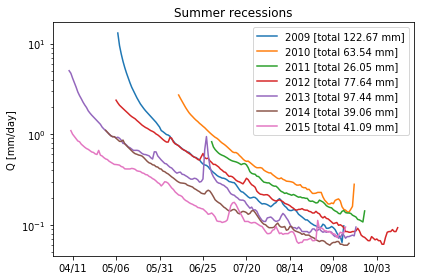

In [73]:
starts = pd.to_datetime(['5/6/09', '6/10/10', '6/29/11', '5/4/12', '4/8/13', '4/29/14', '4/9/15'])
ends = pd.to_datetime(['9/13/09', '9/19/10', '9/25/11', '10/13/12', '9/20/13', '9/16/14', '9/14/15'])

summerflows = []
f, ax = plt.subplots(1,figsize=(6,4))
tillend = []
for i in range(len(starts)):
    summerflows.append(dfq[starts[i]:ends[i]].q.sum())
    doy = dfq[starts[i]:ends[i]].index.dayofyear
    tot = dfq[starts[i]:ends[i]].q.sum()
#     print(dfq[starts[i]:ends[i]].q.min())
#     print(365 - doy[-1])
    tillend.append((365 - doy[-1])*dfq[starts[i]:ends[i]].q.min())
    print(tot)
    ax.plot(doy, dfq[starts[i]:ends[i]].q, label=str(dfq[starts[i]:ends[i]].index.year[0]) + ' [total %.2f'%tot + ' mm]')
    
labs = ax.get_xticklabels()
vals = ax.get_xticks()



ax.set_yscale('log')

for i in range(len(labs)):
    shift = datetime.timedelta(days=vals[i])
    labdate = pd.to_datetime('2001-01-01') + shift
    labs[i] = labdate.strftime('%m/%d')
    
ax.set_xticklabels(labs)
ax.set_title('Summer recessions')
ax.legend()
ax.set_ylabel('Q [mm/day]')
f.tight_layout()
# f.savefig('./plots/summer_recessions.pdf')

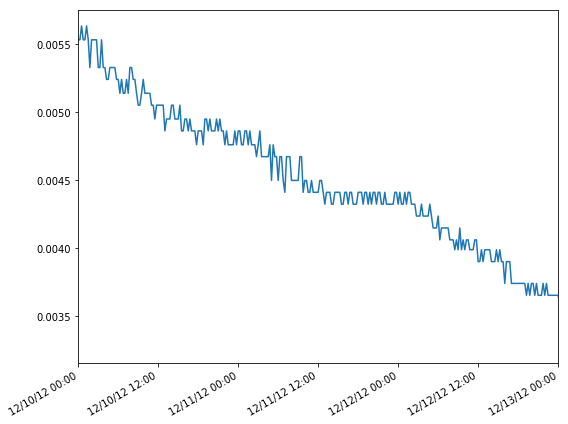

In [93]:
q = pd.read_pickle('../dynamic_storage/data/df_elder.p')
q = q.loc['12-10-2012':'12-13-2012']

# Set a label frequency
tick_frequency = '12H'
# get datetimes for the ticks you want, at the desired frequency
ticks = pd.date_range('12-10-2012', '12-13-2012', freq=tick_frequency)
f,ax = plt.subplots(1,figsize=(8,6))
ax.plot(q.index, q.q)
# Show only the ticks you want
# ax.set_xlabel('')
ax.set_xticks(ticks)
# Create a list of labels corresponding to those ticks
# Notice the strftime function; this function is amazing
# and will print a datetime in any format you want
# https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior
labels = [ticks[i].strftime('%D %H:%M') for i in range(len(ticks))]
# set the xticks to have the above labels
ax.set_xticklabels(labels)
# this is a nice function that kinda auto-rotates labels for you
# f.autofmt_xdate()
# alternatively, could tell it the rotation angle 
f.autofmt_xdate()
ax.set_xlim(['12-10-2012', '12-13-2012'])
f.tight_layout()
f.savefig('./test.pdf')

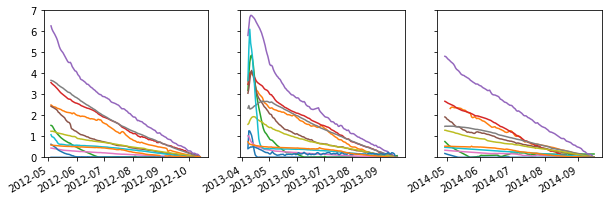

In [15]:
starts = pd.to_datetime([ '2012-05-04', '2013-04-08', '2014-04-29'])
stops = pd.to_datetime([ '2012-10-13', '2013-09-20', '2014-09-16'])



ppt = pd.read_pickle('./data/elder_ppt.p')
q = pd.read_pickle('./data/elder_runoff.p')
ppt['cumulative'] = 0
q['cumulative'] = 0
years = list(set(ppt.index.year))
years.sort()
dt = 15.0/60.0/24.0
for year in years[:-1]:
    wystart = '10-' + str(year)
    wyend = '9-' + str(year+1)
    ppt.loc[wystart:wyend, 'cumulative'] = ppt['ppt'].loc[wystart:wyend].cumsum()
    q.loc[wystart:wyend, 'cumulative'] = q.q.loc[wystart:wyend].cumsum()

    
wells = list(dfs.keys())
cm = sns.color_palette('bright', len(wells))
maxwell = {}
minwell = {}
toconcat = []
f, axs = plt.subplots(1,3, figsize=(10,3))
for i in range(len(wells)):
    well = wells[i]
    df = dfs[well]
    df.sort_index(inplace=True)
    df.interpolate(method='linear',inplace=True)
    df = df.resample('D').mean()
    df.interpolate(method='linear',inplace=True, limit=10)
    
    for k in range(len(starts)): 
        start = starts[k]
        stop = stops[k]
        idx = df.val.loc[starts[k]:stops[k]].index.to_pydatetime()
        axs[k].plot(idx, df.val.loc[starts[k]:stops[k]] - df.val.loc[starts[k]:stops[k]].min())
        axs[k].set_ylim([0,7])
        if k>0:
            axs[k].set_yticklabels(['' for i in range(len(axs[k].get_yticklabels()))])
f.autofmt_xdate()
